# This notebook is for the Fair-Shapely experiment

In [29]:
%reload_ext autoreload
%autoreload 2

### 1. Import libraries

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### 2. Import dataset

In [46]:
from src.data.unified_dataloader import load_dataset

_, processed_compas = load_dataset('compas4race')
target_name = 'two_year_recid'
processed_compas.head(5)

,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_F,c_charge_degree_M,type_of_assessment_Risk of Recidivism,score_text_High,score_text_Low,score_text_Medium,two_year_recid
0,1,-0.061334,1,-0.162011,-0.195526,-0.227625,-0.735792,1,0,1,0,1,0,1
1,1,-0.901239,1,-0.162011,-0.195526,1.703263,0.059694,1,0,1,0,1,0,1
2,1,-0.985229,1,-0.162011,1.785502,-0.227625,-0.536921,1,0,1,1,0,0,0
3,1,0.526600,0,-0.162011,-0.195526,-0.227625,2.048409,1,0,1,0,0,1,1
4,0,0.358619,0,-0.162011,-0.195526,-0.227625,-0.735792,0,1,1,0,1,0,0


### 3. Split label/unlabel data, split train/test data.

In [47]:
'''UCI dataset'''
# df = processed_default_credit.copy()
# X = df.drop('income', axis=1)
# y = df['income']

'''German Credit dataset'''
# df = processed_german_credit.copy()
# X = df.drop('Risk', axis=1)
# y = df['Risk']

'''Default Credit dataset'''
# df = processed_default_credit.copy()
# X = df.drop(target_name, axis=1)
# y = df[target_name]

'''COMPAS FOR RACE'''
df = processed_compas.copy()
target_name = 'two_year_recid'
X = df.drop(target_name, axis=1)
y = df[target_name]


# 10% X_label, 90% X_unlabel
X_label, X_unlabel, y_label, y_unlabel = train_test_split(X, y, test_size=0.9, random_state=25) 
print(f'X_label shape: {X_label.shape}')
print(f'X_unlabel shape: {X_unlabel.shape}')
print('---------------------------------')
# split labeled data into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X_label, y_label, test_size=0.3, random_state=25) 
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_label shape: (615, 13)
X_unlabel shape: (5535, 13)
---------------------------------
X_train shape: (430, 13)
X_test shape: (185, 13)


### 4. Train the original model

In [48]:
model = XGBClassifier()  # 可以替换为 RandomForestClassifier() 等其他模型
model.fit(X_train,y_train)

# 预测和评估
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6486486486486487


In [51]:
from src.baselines import Baseline

baseline = Baseline(X_train, y_train, X_test, y_test, X_unlabel, model='xgboost', sen_attri="race")
baseline.get_baseline1()

2025-01-28 23:41:03.061 | INFO     | src.baselines:get_baseline1:43 - baseline1: 使用了xgboost, Accuracy: 0.649, DR: 0.18055


In [52]:
'''
使用nearest neighbour在unlabel data中挑选与X_train相近的数据, 他们label使用与之匹配的X_train的label, 然后加入training set.   (结果不行)
'''
baseline.get_baseline2()

2025-01-28 23:41:07.274 | INFO     | src.baselines:get_baseline2:69 - baseline2: 使用了xgboost, proportion: 0.2, num_new_data: 1, Accuracy: 0.632, DR: 0.13951
2025-01-28 23:41:07.381 | INFO     | src.baselines:get_baseline2:69 - baseline2: 使用了xgboost, proportion: 0.2, num_new_data: 2, Accuracy: 0.638, DR: 0.16708
2025-01-28 23:41:07.516 | INFO     | src.baselines:get_baseline2:69 - baseline2: 使用了xgboost, proportion: 0.2, num_new_data: 3, Accuracy: 0.649, DR: 0.15626
2025-01-28 23:41:07.622 | INFO     | src.baselines:get_baseline2:69 - baseline2: 使用了xgboost, proportion: 0.4, num_new_data: 1, Accuracy: 0.622, DR: 0.18684
2025-01-28 23:41:07.765 | INFO     | src.baselines:get_baseline2:69 - baseline2: 使用了xgboost, proportion: 0.4, num_new_data: 2, Accuracy: 0.665, DR: 0.17871
2025-01-28 23:41:07.934 | INFO     | src.baselines:get_baseline2:69 - baseline2: 使用了xgboost, proportion: 0.4, num_new_data: 3, Accuracy: 0.659, DR: 0.19098
2025-01-28 23:41:08.048 | INFO     | src.baselines:get_baseline2

In [53]:
'''
使用nearest neighbour在unlabel data中挑选与X_train相近的数据, 直接把挑选出来的数据输入进model, 预测结果作为新的label, 然后加入training set. （效果很好）
'''
baseline.get_baseline3()

2025-01-28 23:41:10.244 | INFO     | src.baselines:get_baseline3:104 - baseline3: 使用了xgboost, proportion: 0.2, num_new_data: 1, Accuracy: 0.665, DR: 0.20328
2025-01-28 23:41:10.396 | INFO     | src.baselines:get_baseline3:104 - baseline3: 使用了xgboost, proportion: 0.2, num_new_data: 2, Accuracy: 0.649, DR: 0.16904
2025-01-28 23:41:10.625 | INFO     | src.baselines:get_baseline3:104 - baseline3: 使用了xgboost, proportion: 0.2, num_new_data: 3, Accuracy: 0.654, DR: 0.15381
2025-01-28 23:41:10.858 | INFO     | src.baselines:get_baseline3:104 - baseline3: 使用了xgboost, proportion: 0.4, num_new_data: 1, Accuracy: 0.665, DR: 0.22543
2025-01-28 23:41:11.096 | INFO     | src.baselines:get_baseline3:104 - baseline3: 使用了xgboost, proportion: 0.4, num_new_data: 2, Accuracy: 0.649, DR: 0.20167
2025-01-28 23:41:11.385 | INFO     | src.baselines:get_baseline3:104 - baseline3: 使用了xgboost, proportion: 0.4, num_new_data: 3, Accuracy: 0.654, DR: 0.17966
2025-01-28 23:41:11.581 | INFO     | src.baselines:get_bas

### 5. Start the experiment!

>1. 只使用10%的labeled data 查看模型结果-baseline （见4, 5）
>
>2. 只使用10%的labeled data + sex balance查看模型结果
>
>3. 使用10%的labeled data， 再使用unlabel data把labeled data中的sex补齐。（使用model预测的值对unlabel data贴标签）
>
>4. 使用10%的labeled data， 再使用unlabel data时候，让新增的data中 sex balanced（使用model预测的值对unlabel data贴标签）
>
>5. 使用10%的labeled data + sex balance + new data (from unlabeled data) + sex balance + 使用labeled data中最相似的instance的标签
>
>6. 使用10%的labeled data + sex balance + new data (from unlabeled data) + sex balance + 通过pretrained model对data进行label标注
>
>7.☆☆  这里的sex balance是如何选取好点？ 是分别找sex=0和sex=1的nearest neighbour(此处数量怎么限制？按照少数的来？)。
>   还是把他们放在一个大池子里。统一挑出来，最后再限制个数为min(num_sex0, num_sex1)， 如果这样的话，对unlabeled data标注方式感觉不能直接使用原标签，是否用ml预测的结果会更好一点？

In [54]:
from src.experiments import Experiment

In [55]:
my_experiment = Experiment(
            orginal_model=model, 
            X_train=X_train, 
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            X_unlabel=X_unlabel,
            y_unlabel=y_unlabel,
            dataset_name='compas4race', )
'''
对于german credit，需要把 self.limited_values_range = np.arange(1, non_zero_count, 1)中的1改成50
'''

'\n对于german credit，需要把 self.limited_values_range = np.arange(1, non_zero_count, 1)中的1改成50\n'

In [56]:
# new_models_DR_values = my_experiment.get_result(
#             sex_balance = False, 
#             proportion = 0.5,
#             replacement = True, 
#             num_new_data = 3,
#             matcher = 'nn')

new_models_DR_values,_ = my_experiment.get_sex_separate_nn_result(
    sex_balance=False,
    proportion=0.6,
    replacement=True,
    num_new_data=3,
    matcher='nn',
    match_method='sex_cross'
)


开始第1步, 从X_unlabel中按照比例随机抽出num_new_data组数据
开始第2步, X_label分别与random_picks[0,1,2....,num_new_data-1]进行matching, 找到matching的数据
开始第3步, 计算每组数据的fairness shapley value
开始第4步, 对shapely value不取绝对值, 然后把负值直接变成0, 然后在归一化, 得到新的varphi
开始第5步, 计算q
开始第6步, 计算出总共可以修改的actions number, 并且把新的unlabel data整合好, 加入到X_train中, 返回合并后的数据, 重新训练模型, 并且评估性能
Total number of non-zero values across all varphis: 1325
Proporation: 0.6, new_data_number: 3 训练结束, match_method:sex_cross,DR值已经保存, 可以进行可视化
-----------------------------------------------------------------------------


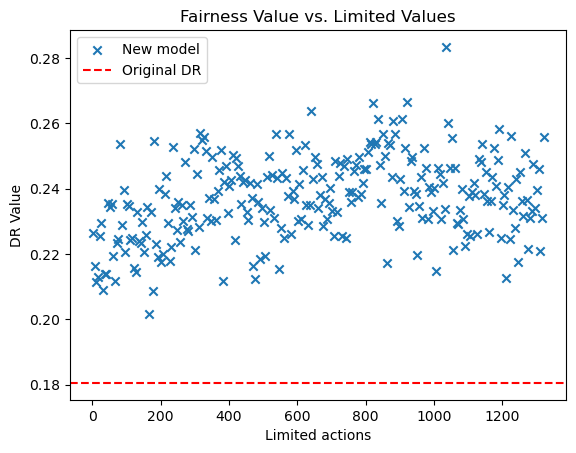

In [57]:
'''
考虑到这个dataset有大量的改动没有用，只会增加DR值，所以我选择了只改动 number_actions的1/3个数
'''

my_experiment.visualize(new_models_DR_values)

开始第3步, 计算每组数据的fairness shapley value
开始第4步, 对shapely value不取绝对值, 然后把负值直接变成0, 然后在归一化, 得到新的varphi
开始第5步, 计算q
开始第6步, 计算出总共可以修改的actions number, 并且把新的unlabel data整合好, 加入到X_train中, 返回合并后的数据, 重新训练模型, 并且评估性能
Total number of non-zero values across all varphis: 260
Proporation: 0.2, new_data_number: 1 训练结束, match_method:together,DR值已经保存, 可以进行可视化
-----------------------------------------------------------------------------
开始第3步, 计算每组数据的fairness shapley value
开始第4步, 对shapely value不取绝对值, 然后把负值直接变成0, 然后在归一化, 得到新的varphi
开始第5步, 计算q
开始第6步, 计算出总共可以修改的actions number, 并且把新的unlabel data整合好, 加入到X_train中, 返回合并后的数据, 重新训练模型, 并且评估性能
Total number of non-zero values across all varphis: 463
Proporation: 0.2, new_data_number: 2 训练结束, match_method:together,DR值已经保存, 可以进行可视化
-----------------------------------------------------------------------------
开始第3步, 计算每组数据的fairness shapley value
开始第4步, 对shapely value不取绝对值, 然后把负值直接变成0, 然后在归一化, 得到新的varphi
开始第5步, 计算q
开始第6步, 计算出总共可以修改的actions number, 并且把新的unlabel data整合好, 加入到X_t

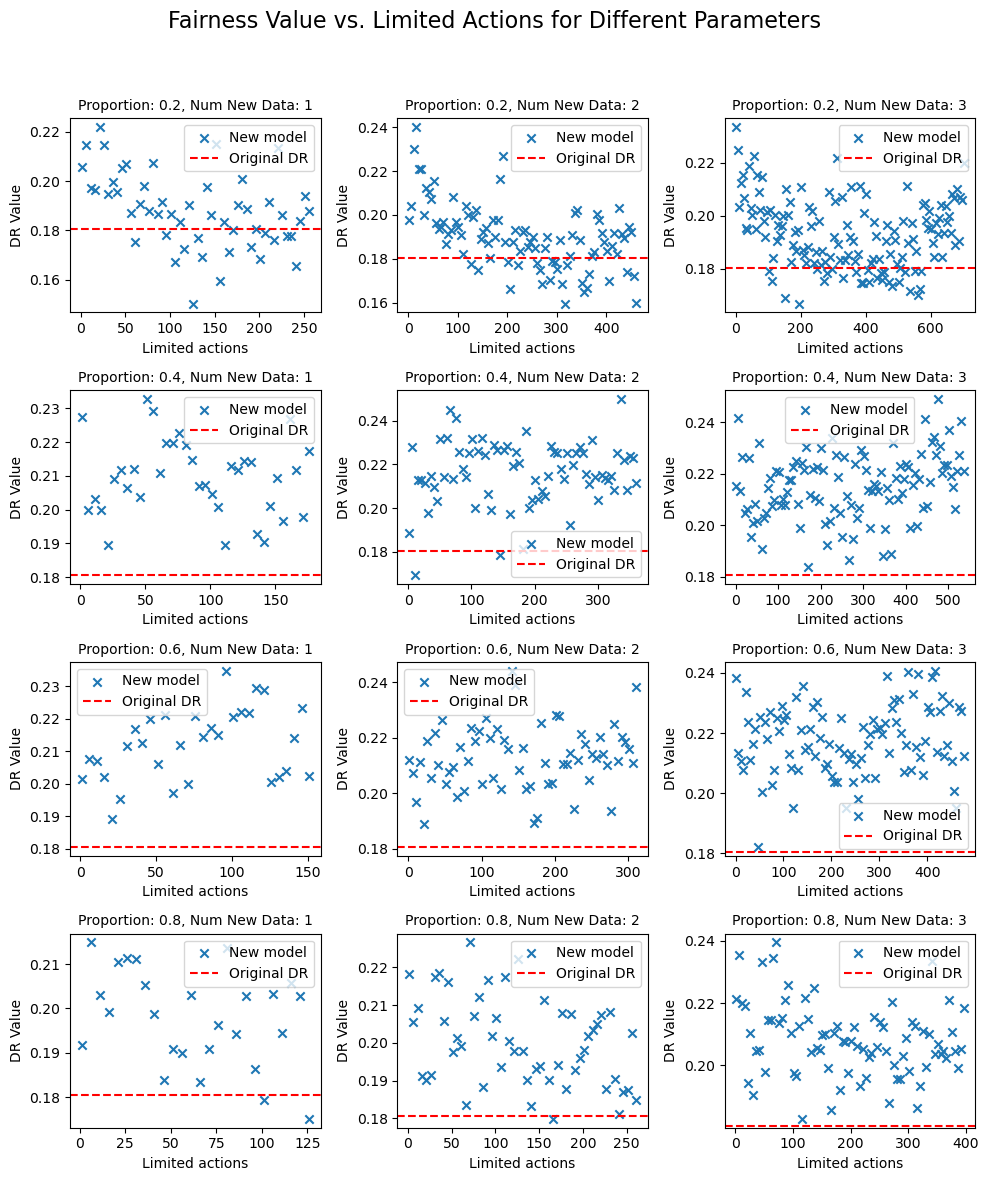

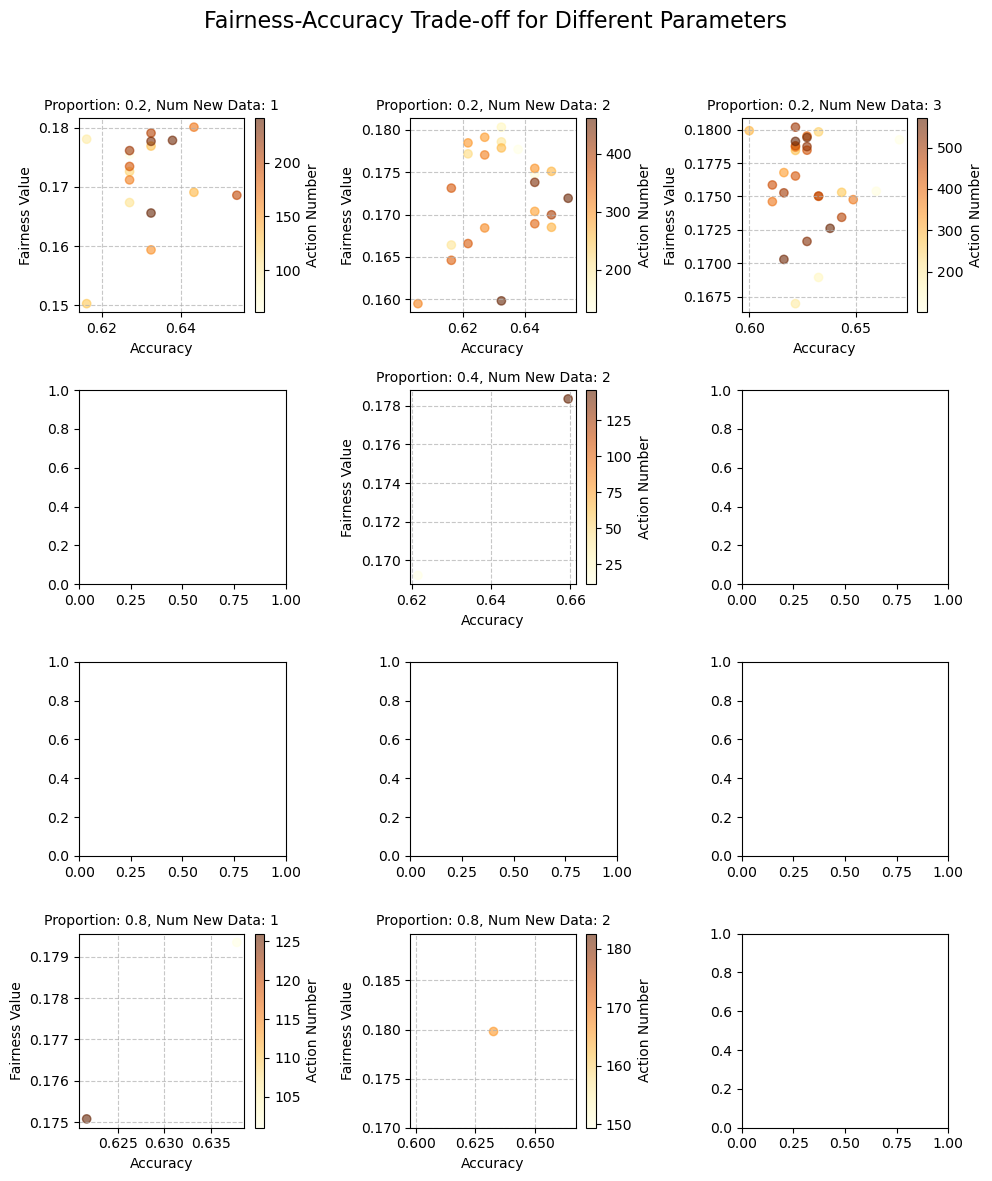

In [59]:
results = my_experiment.combination(match_met='together')

开始第1步, 从X_unlabel中按照比例随机抽出num_new_data组数据
开始第2步, X_label分别与random_picks[0,1,2....,num_new_data-1]进行matching, 找到matching的数据
开始第3步, 计算每组数据的fairness shapley value
开始第4步, 对shapely value不取绝对值, 然后把负值直接变成0, 然后在归一化, 得到新的varphi
开始第5步, 计算q
开始第6步, 计算出总共可以修改的actions number, 并且把新的unlabel data整合好, 加入到X_train中, 返回合并后的数据, 重新训练模型, 并且评估性能
Total number of non-zero values across all varphis: 220
Proporation: 0.2, new_data_number: 1 训练结束, match_method:sex_separate,DR值已经保存, 可以进行可视化
-----------------------------------------------------------------------------
开始第1步, 从X_unlabel中按照比例随机抽出num_new_data组数据
开始第2步, X_label分别与random_picks[0,1,2....,num_new_data-1]进行matching, 找到matching的数据
开始第3步, 计算每组数据的fairness shapley value
开始第4步, 对shapely value不取绝对值, 然后把负值直接变成0, 然后在归一化, 得到新的varphi
开始第5步, 计算q
开始第6步, 计算出总共可以修改的actions number, 并且把新的unlabel data整合好, 加入到X_train中, 返回合并后的数据, 重新训练模型, 并且评估性能
Total number of non-zero values across all varphis: 446
Proporation: 0.2, new_data_number: 2 训练结束, match_method:sex_separate,DR值已经保存, 

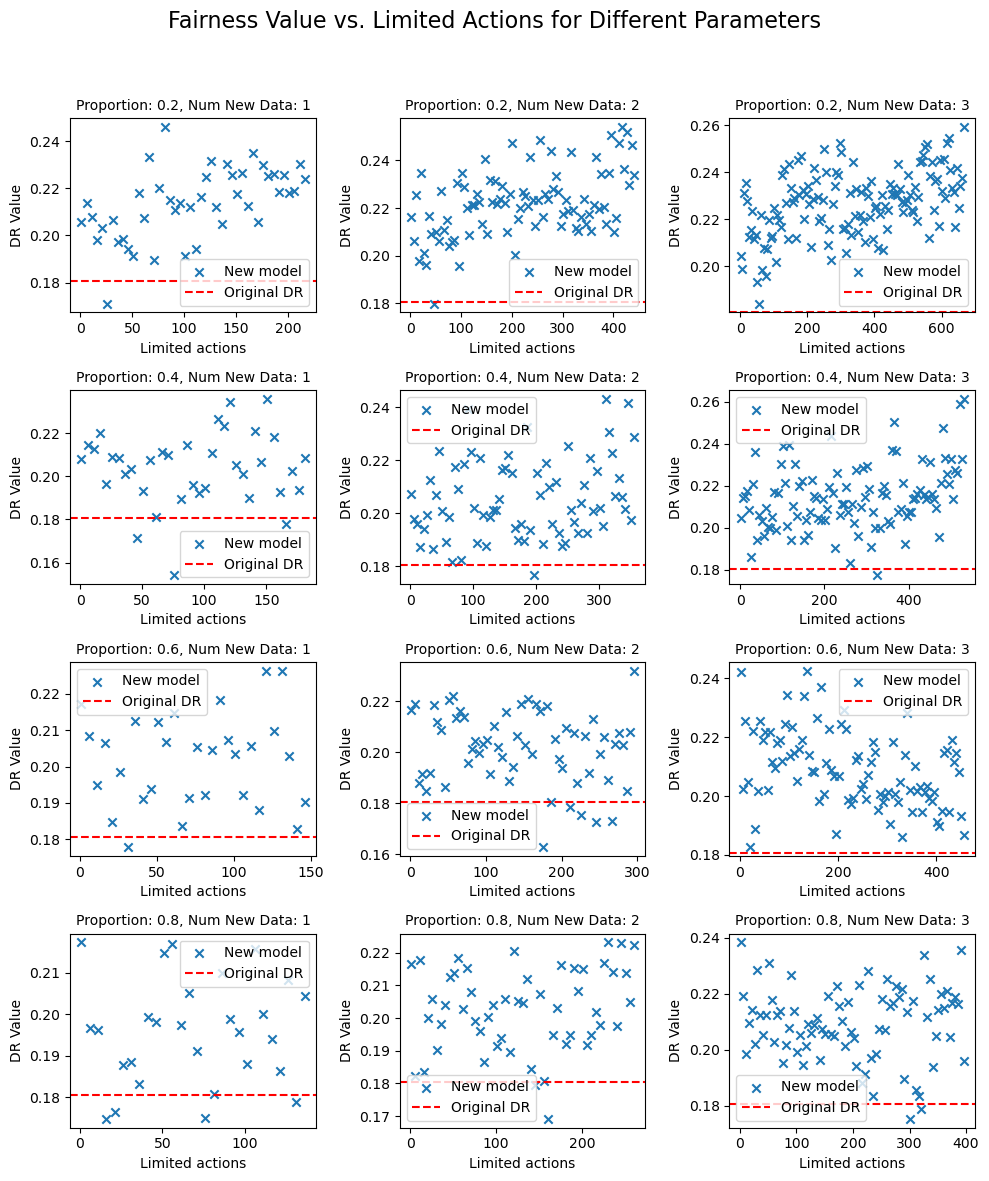

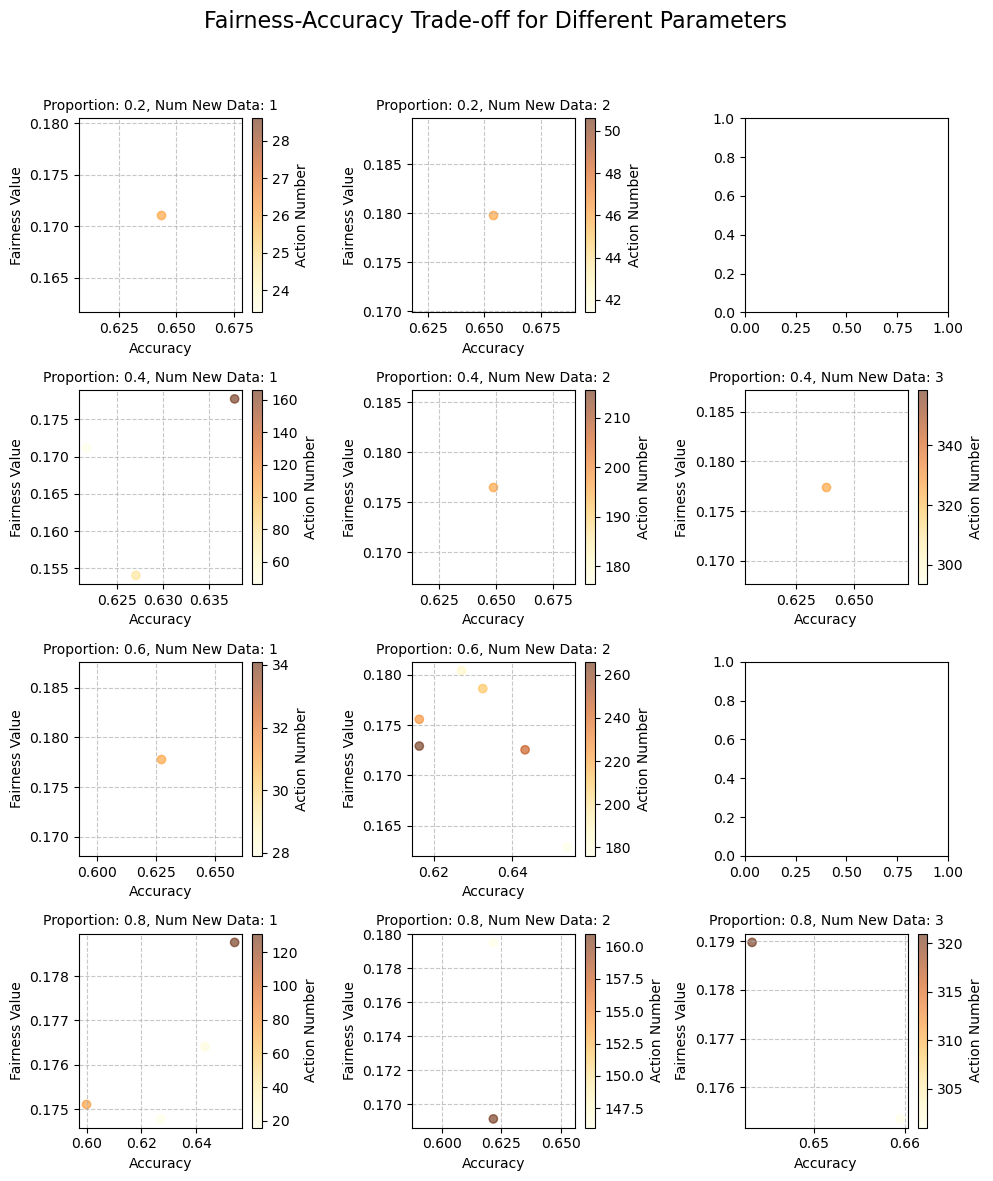

In [60]:
results_sex_separate = my_experiment.combination(match_met='sex_separate')

开始第1步, 从X_unlabel中按照比例随机抽出num_new_data组数据
开始第2步, X_label分别与random_picks[0,1,2....,num_new_data-1]进行matching, 找到matching的数据
开始第3步, 计算每组数据的fairness shapley value
开始第4步, 对shapely value不取绝对值, 然后把负值直接变成0, 然后在归一化, 得到新的varphi
开始第5步, 计算q
开始第6步, 计算出总共可以修改的actions number, 并且把新的unlabel data整合好, 加入到X_train中, 返回合并后的数据, 重新训练模型, 并且评估性能
Total number of non-zero values across all varphis: 501
Proporation: 0.2, new_data_number: 1 训练结束, match_method:sex_cross,DR值已经保存, 可以进行可视化
-----------------------------------------------------------------------------
开始第1步, 从X_unlabel中按照比例随机抽出num_new_data组数据
开始第2步, X_label分别与random_picks[0,1,2....,num_new_data-1]进行matching, 找到matching的数据
开始第3步, 计算每组数据的fairness shapley value
开始第4步, 对shapely value不取绝对值, 然后把负值直接变成0, 然后在归一化, 得到新的varphi
开始第5步, 计算q
开始第6步, 计算出总共可以修改的actions number, 并且把新的unlabel data整合好, 加入到X_train中, 返回合并后的数据, 重新训练模型, 并且评估性能
Total number of non-zero values across all varphis: 995
Proporation: 0.2, new_data_number: 2 训练结束, match_method:sex_cross,DR值已经保存, 可以进行可视

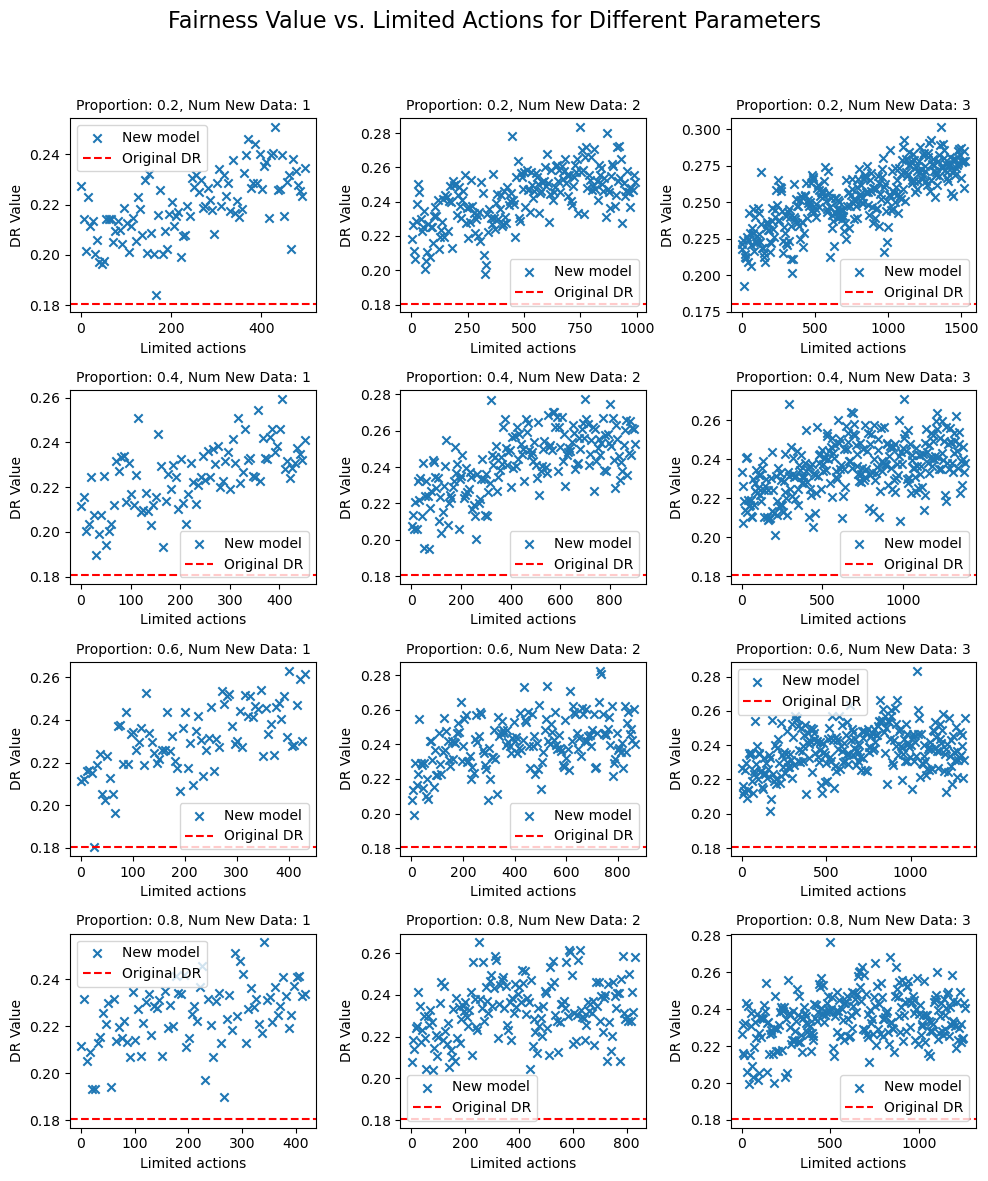

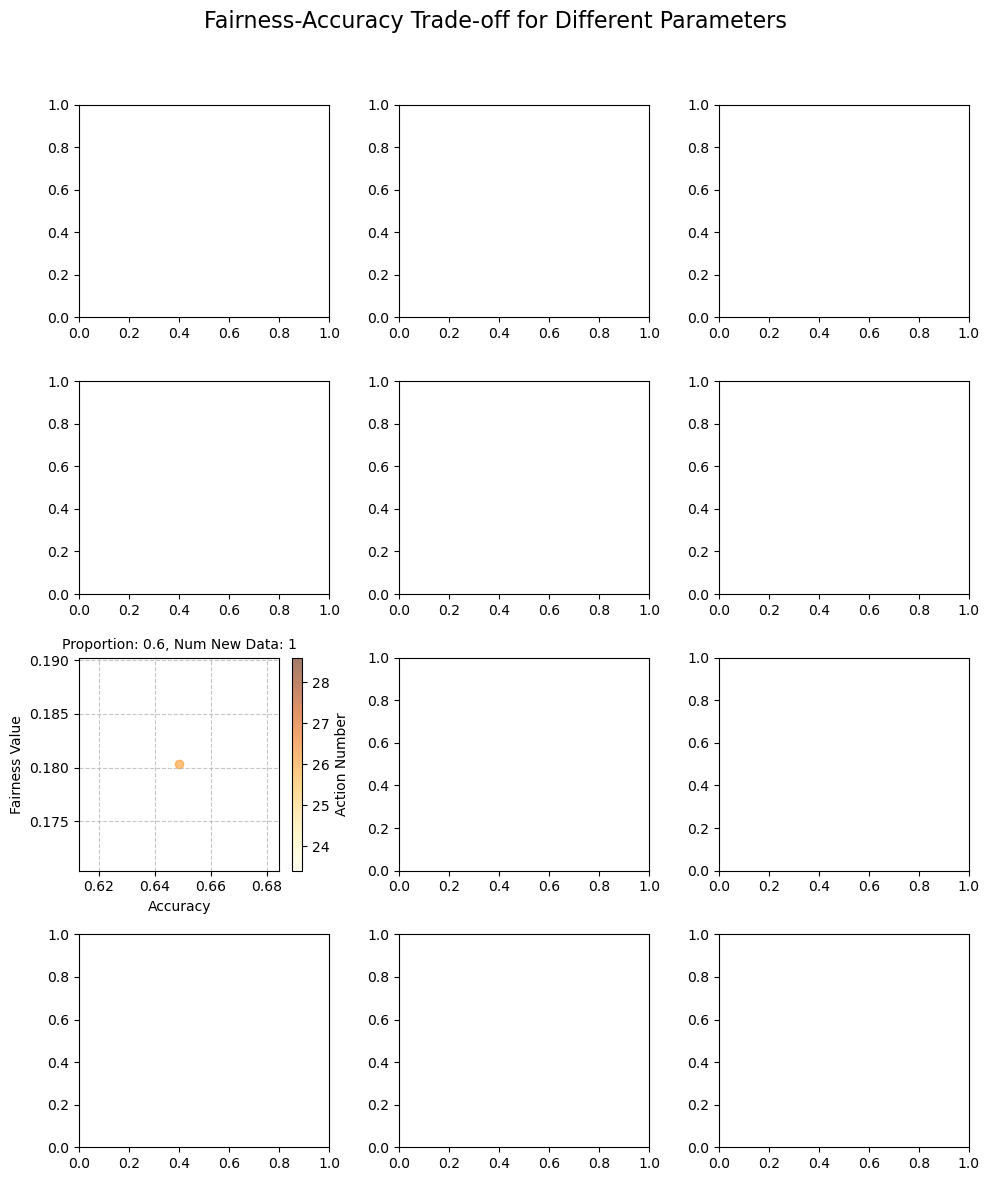

In [58]:
results_sex_cross = my_experiment.combination(match_met='sex_cross')